In [3]:
import tensorflow as tf
import numpy as np
import json
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import KFold

# Function to resize labels
def resize_labels(labels, original_size, new_size):
    # Adjust the label coordinates for the new image size
    scale_x = new_size[1] / original_size[1]
    scale_y = new_size[0] / original_size[0]
    resized_labels = []
    for label in labels:
        resized_label = {
            'x': label['x'] * scale_x,
            'y': label['y'] * scale_y,
            'radius': label['radius'] * scale_x  # Assuming uniform scaling in x and y
        }
        resized_labels.append(resized_label)
    return resized_labels


# Function to convert labels to EfficientDet format
def convert_to_efficientdet_format(labels, image_shape):
    efficientdet_labels = []
    for label in labels:
        # Calculate the coordinates of the upper left and lower right corners
        xmin = (label['x'] - label['radius']) / image_shape[1]
        ymin = (label['y'] - label['radius']) / image_shape[0]
        xmax = (label['x'] + label['radius']) / image_shape[1]
        ymax = (label['y'] + label['radius']) / image_shape[0]
        # EfficientDet format [ymin, xmin, ymax, xmax]
        efficientdet_labels.append([
            max(0, ymin), max(0, xmin), min(1, ymax), min(1, xmax)
        ])
    return efficientdet_labels


# Function to load images and labels
def load_images_and_labels(image_dir, label_dir, original_size=(1024, 1024), new_size=(512, 512)):
    image_files = [os.path.join(image_dir, file) for file in sorted(os.listdir(image_dir)) if file.endswith('.png')]
    label_files = [os.path.join(label_dir, file) for file in sorted(os.listdir(label_dir)) if file.endswith('.json')]
    
    images = []
    all_boxes = []

    for image_file, label_file in zip(image_files, label_files):
        # Load and resize image
        image = load_img(image_file, color_mode='rgb', target_size=new_size)
        # Convert the image to an array and scale the pixel values to [-1, 1]
        image = (img_to_array(image) / 127.5) - 1
        images.append(image)

        # Load labels and adjust for new image size
        with open(label_file, 'r') as file:
            json_data = json.load(file)
        resized_json_data = resize_labels(json_data, original_size=original_size, new_size=new_size)
        boxes = convert_to_efficientdet_format(resized_json_data, new_size)
        all_boxes.append(boxes)
    
    return np.array(images), all_boxes


# Function to pad labels to a fixed size
def pad_labels(labels, max_boxes=250, pad_value=0):
    padded_labels = []
    for label in labels:
        padded_label = np.zeros((max_boxes, 4), dtype=np.float32) + pad_value
        num_boxes = min(len(label), max_boxes)
        padded_label[:num_boxes] = label[:num_boxes]
        padded_labels.append(padded_label)
    return np.array(padded_labels)

# Function to prepare the dataset
def prepare_dataset(images, boxes, batch_size, num_boxes=250):
    images = tf.constant(images, dtype=tf.float32)
    boxes = pad_labels(boxes, max_boxes=num_boxes)
    boxes = tf.constant(boxes, dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices((images, boxes))
    dataset = dataset.shuffle(len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [4]:
batch_size = 2
# image_dir = './TMA_WSI_Padded_PNGs'
image_dir = './image_labels'
label_dir = './TMA_WSI_Labels_updated'
images, boxes = load_images_and_labels(image_dir, label_dir)
# Map this preprocessing function to your dataset


# Assuming we have only one class for object detection and 100 boxes per image
num_boxes = 250  # Maximum number of boxes per image, adjust as needed

dataset = prepare_dataset(images, boxes, batch_size, num_boxes=num_boxes)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
def create_object_detection_model(num_boxes):
    backbone = tf.keras.applications.MobileNetV2(input_shape=[512, 512, 3], include_top=False, weights='imagenet')
    backbone.trainable = False

    x = backbone.output
    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Output layer for bounding box predictions
    # The output is reshaped to [batch_size, num_boxes, 4]
    boxes_output_flat = layers.Dense(num_boxes * 4, activation='sigmoid', name='boxes_output')(x)
    boxes_output = layers.Reshape((num_boxes, 4))(boxes_output_flat)

    model = models.Model(inputs=backbone.input, outputs=boxes_output)
    
    return model


model = create_object_detection_model(num_boxes)

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
from tensorflow.keras import layers, models

def create_custom_model(input_shape, num_boxes):
    inputs = layers.Input(shape=input_shape)

    # Add your custom layers here
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    # Output layer for bounding box predictions
    # The output is reshaped to [batch_size, num_boxes, 4]
    boxes_output_flat = layers.Dense(num_boxes * 4, activation='sigmoid', name='boxes_output')(x)
    boxes_output = layers.Reshape((num_boxes, 4))(boxes_output_flat)

    model = models.Model(inputs=inputs, outputs=boxes_output)
    
    return model

# Example usage
input_shape = (512, 512, 3)
num_boxes = 250

model = create_custom_model(input_shape, num_boxes)


In [11]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
import datetime
import os
from tensorflow.keras.callbacks import EarlyStopping


# Define the Smooth L1 Loss Function
def smooth_l1_loss(sigma=3.0):
    sigma_squared = sigma ** 2
    
    def smooth_l1_loss_fixed(y_true, y_pred):
        regression_diff = y_true - y_pred
        regression_diff = tf.abs(regression_diff)
        regression_loss = tf.where(
            tf.less(regression_diff, 1.0 / sigma_squared),
            0.5 * sigma_squared * tf.pow(regression_diff, 2),
            regression_diff - 0.5 / sigma_squared
        )
        regression_loss = tf.reduce_sum(regression_loss, axis=-1)
        return tf.reduce_mean(regression_loss)
    
    return smooth_l1_loss_fixed
# Compile the Model with the Custom Loss
model.compile(optimizer='adam',
              loss=smooth_l1_loss(),  # Only use smooth L1 loss for bounding box predictions
              metrics=['mean_squared_error'])  # Added a metric for bounding box prediction quality

# Set up TensorBoard logging
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Set up checkpoints to save the model
checkpoint_dir = "checkpoints/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_path = checkpoint_dir + "cp-{epoch:04d}.ckpt"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=False  # Set to True to save only the best model based on validation loss
)

# Define a Learning Rate Schedule
def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    elif epoch%10 == 0:
        return lr * tf.math.exp(-0.1)
    else:
        return lr

learning_rate_callback = LearningRateScheduler(scheduler)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min')



In [12]:
# Initialize a list to store the results
results = []

# Split the dataset into 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

fold_no = 1
for train_index, val_index in kf.split(images):
    train_images, val_images = images[train_index], images[val_index]
    train_boxes, val_boxes = [boxes[i] for i in train_index], [boxes[i] for i in val_index]

    # Prepare the training and validation datasets
    train_dataset = prepare_dataset(train_images, train_boxes, batch_size, num_boxes=num_boxes)
    val_dataset = prepare_dataset(val_images, val_boxes, batch_size, num_boxes=num_boxes)

    # Create a new instance of the model (to reset weights)
    model = create_object_detection_model(num_boxes)

    # Compile the model
    model.compile(optimizer='adam', loss=smooth_l1_loss(), metrics=['mean_squared_error'])

    print(f'Training for fold {fold_no} ...')

    # Fit the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=350,
        callbacks=[
            tensorboard_callback, 
            checkpoint_callback, 
            learning_rate_callback, 
            early_stopping_callback  # Add the early stopping callback here
        ]
    )


    # Save the model
    model.save(f'model_fold_{fold_no}.h5')

    # Log the results
    val_loss, val_mse = model.evaluate(val_dataset)
    results.append({'fold': fold_no, 'val_loss': val_loss, 'val_mse': val_mse})

    # Increase the fold number
    fold_no += 1

Training for fold 1 ...
Epoch 1/350
9/9 [==============================] - ETA: 0s - loss: 1.0632 - mean_squared_error: 0.1348
Epoch 1: saving model to checkpoints\cp-0001.ckpt
9/9 [==============================] - 6s 440ms/step - loss: 1.0632 - mean_squared_error: 0.1348 - val_loss: 0.8143 - val_mean_squared_error: 0.0898 - lr: 0.0010
Epoch 2/350
9/9 [==============================] - ETA: 0s - loss: 0.7638 - mean_squared_error: 0.0982
Epoch 2: saving model to checkpoints\cp-0002.ckpt
9/9 [==============================] - 3s 398ms/step - loss: 0.7638 - mean_squared_error: 0.0982 - val_loss: 0.6088 - val_mean_squared_error: 0.0618 - lr: 0.0010
Epoch 3/350
9/9 [==============================] - ETA: 0s - loss: 0.5649 - mean_squared_error: 0.0681
Epoch 3: saving model to checkpoints\cp-0003.ckpt
9/9 [==============================] - 3s 398ms/step - loss: 0.5649 - mean_squared_error: 0.0681 - val_loss: 0.6010 - val_mean_squared_error: 0.0569 - lr: 0.0010
Epoch 4/350
9/9 [==============

KeyboardInterrupt: 

In [ ]:
import pandas as pd
# Convert the results to a DataFrame and save to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv('cross_validation_results.csv', index=False)

print("Cross-validation results saved to 'cross_validation_results.csv'")

Cross-validation results saved to 'cross_validation_results.csv'


In [ ]:
def load_model_for_fold(fold_n):
    """
    Load the model for a specific fold.

    Args:
    fold_n: The fold number for which to load the model.

    Returns:
    The loaded model.
    """
    model_path = f'model_fold_{fold_n}.h5'
    return tf.keras.models.load_model(model_path, custom_objects={'smooth_l1_loss_fixed': smooth_l1_loss()})

def get_validation_data_for_fold(fold_n, images, boxes, kf):
    """
    Get the validation data for a specific fold.

    Args:
    fold_n: The fold number for which to get the validation data.
    images: The full images dataset.
    boxes: The full boxes dataset.
    kf: The KFold object used for splitting.

    Returns:
    A tuple of (validation_images, validation_boxes).
    """
    for i, (train_index, val_index) in enumerate(kf.split(images)):
        if i == fold_n - 1:  # fold_n is 1-indexed
            return images[val_index], [boxes[j] for j in val_index]
    raise ValueError(f"Fold {fold_n} not found")


In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_image_with_boxes(image, true_boxes, pred_boxes, figsize=(10, 10)):
    """
    Plots an image with overlaid true and predicted bounding boxes, ensuring visibility even when boxes overlap.
    
    Args:
    image: The image as a NumPy array, normalized between [-1, 1].
    true_boxes: A NumPy array of true bounding boxes of shape (N, 4), where N is the number of boxes,
                and each box is defined as (ymin, xmin, ymax, xmax).
    pred_boxes: A NumPy array of predicted bounding boxes of shape (N, 4), similar to true_boxes.
    figsize: Size of the figure to display.
    """
    # Rescale the image from [-1,1] to [0,1] for displaying
    image = (image + 1) / 2.0

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)  # If the image is not grayscale, remove cmap='gray'

    img_height, img_width = image.shape[:2]
    
    # Plot true bounding boxes
    for box in true_boxes:
        if np.all(box == 0):
            continue  # Skip boxes that are all zeros (used for padding)
        ymin, xmin, ymax, xmax = box
        ymin *= img_height
        ymax *= img_height
        xmin *= img_width
        xmax *= img_width
        # Use a solid line for true boxes
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='limegreen', facecolor='none', linestyle='-', label='True')
        ax.add_patch(rect)
    
    # Plot predicted bounding boxes
    for box in pred_boxes:
        if np.all(box == 0):
            continue  # Skip boxes that are all zeros (used for padding)
        ymin, xmin, ymax, xmax = box
        ymin *= img_height
        ymax *= img_height
        xmin *= img_width
        xmax *= img_width
        # Use a dashed line for predicted boxes
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='red', facecolor='none', linestyle='--', alpha=1, label='Pred')
        ax.add_patch(rect)

    # Create a legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # This ensures that only one label for each line style is added to the legend
    unique_labels = list(set(labels))
    unique_handles = [by_label[label] for label in unique_labels]
    ax.legend(unique_handles, unique_labels)
    
    plt.show()


In [8]:
# Example usage
fold_n = 9  # Specify the fold number
model = load_model_for_fold(fold_n)

# Assuming 'kf' is your KFold object and 'images', 'boxes' are your full datasets
val_images, val_boxes = get_validation_data_for_fold(fold_n, images, boxes, kf)

# Select an index of an image to display from the validation set
image_index = 0
selected_image = val_images[image_index]
selected_true_boxes = pad_labels([val_boxes[image_index]])

# Predict the bounding boxes for the selected image
pred_boxes = model.predict(selected_image[np.newaxis, ...])

# Plot the image with true and predicted boxes
plot_image_with_boxes(selected_image, selected_true_boxes[0], pred_boxes[0])

NameError: name 'load_model_for_fold' is not defined

1/1 [==============================] - 0s 74ms/step


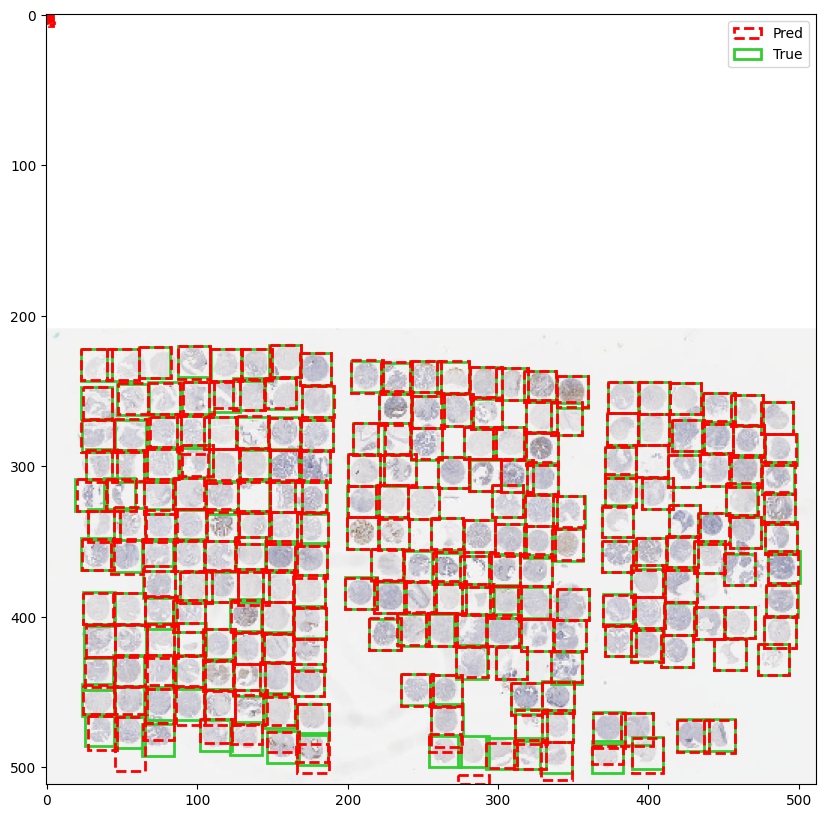

In [ ]:

image = 2 # Select an index of an image to display

pred_boxes = model.predict(images[image:image+1])  # Predict the bounding boxes for the 11th image
# Rescale predictions if necessary here

true_boxes = pad_labels(boxes)


plot_image_with_boxes(images[image], true_boxes[image], pred_boxes[0])